######################################################################################################################################################################################
### Deep Learning algorithms (Neural Network (computer vision) + LSTM) to label youtube videos genre. Using Neural Net to extract video level features and LSTM/GRU to encode sequential strings (audio) through word embedding. Both algorithms later concatenate onto a fully connected network to output the video label genre (E.g. Games, Art & Entertainment, etc.)
** **
######################################################################################################################################################################################

![alt text](uml_diagrams/diagram_nn_stream.png)

######################################################################################################################################################################################
# Step 1: Import libraries for this project

This project will suport library packages ranging from I/O systems, Numpy, Graph tools, Machine Learning frameworks (Keras/Tensorflow & PyTorch) and Visualization tools for each Algorithm. 
** **
######################################################################################################################################################################################

In [1]:
import io
import os
import gc  
import csv
import time
import numpy
import random
import operator
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# # import csv as csv
import urllib.request
import seaborn as sns
import networkx as nx
from numpy import array
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split
############## Pytorch #############
import torch 
import torchvision
import torch.nn as nn
from logger import Logger
import torch.optim as optim
device = torch.device("cuda:0")
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
############## Tensorflow/Keras #############
import keras
import tensorflow as tf
from keras.utils import plot_model
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.layers.merge import dot, concatenate
from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dense, Dropout, Bidirectional, Add, GlobalMaxPooling1D
# ################ Keras GPU Usage ##############
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#################### wandb ####################
import wandb
#################### C/Pickle ####################
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2230509013737522736
]


################################################################################################################################################################################
# Visualize the distributed labels
Below is a visualization of the dataset for this project. We will be uncoverting a combination of spatial and tempoal content. Spatial (video-level data) are high dimensional content compressed from pixels inside a picture to classify objects (computer vision). Temporal (frame-level data) is a sequential set of data to help encode memorization problems like gdp predictions or in this case: audio-classification and a series of video frames. 

** **

################################################################################################################################################################################

In [4]:
with open('../v2/label_names_2018.csv', 'r') as f:
    labelNameList = list(csv.reader(f))
    del labelNameList[0]
avg_labels = pd.read_pickle('savedPickleObjects/avg_labels')
text_labels = pickle.load(open('savedPickleObjects/text_labels_v1.pkl', 'rb'))[0]
distributed_label = pickle.load(open('savedPickleObjects/distributed_label_v1.pkl', 'rb'))[0] 
vlevel_distribution = pickle.load(open('savedPickleObjects/vlevel_distribution_v1.pkl', 'rb'))[0] 

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


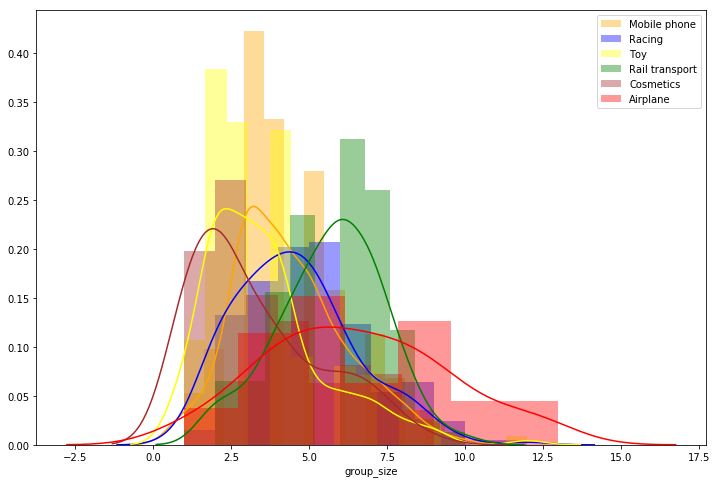

In [5]:
indexes = [19, 20, 25, 46, 40, 49]
colors = ['orange', 'blue', 'yellow', 'green', 'brown', 'red']

plt.figure(figsize=(12,8))
for i, color in zip(indexes, colors):
    sns.distplot(avg_labels[avg_labels['label'] == distributed_label[i]]['group_size'], kde=True, color=color)  

plt.legend([distributed_label[i] for i in indexes])

In [6]:

K_labels = []

for i in distributed_label:
    row = []
    for j in distributed_label:
        i_occurs = [x for x in text_labels if i in x]
        j_and_i_occurs = [x for x in i_occurs if j in x] 
        k = 1.0 * len(j_and_i_occurs)/len(i_occurs) 
        row.append(k) 
    K_labels.append(row)

K_labels = np.array(K_labels)
K_labels = pd.DataFrame(K_labels)
K_labels.columns = distributed_label
K_labels.index = distributed_label


Text(0.5,1,'P(column|row)')

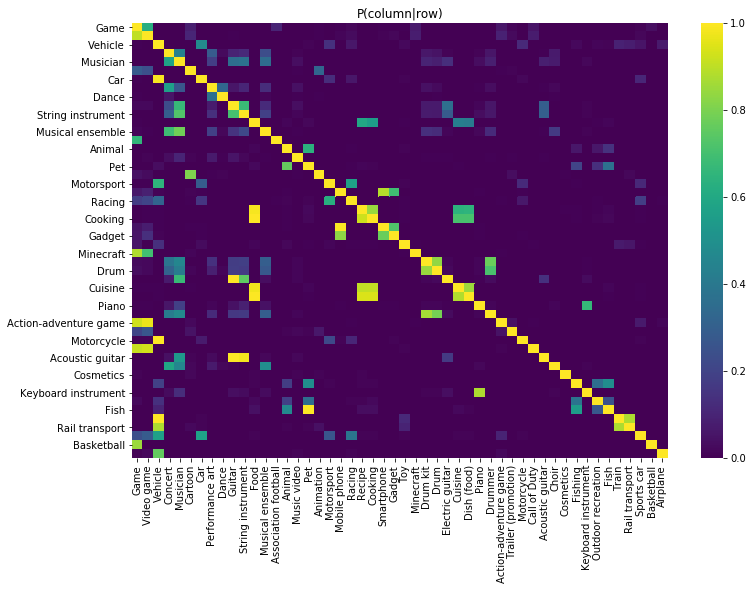

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(K_labels, cmap="viridis")
plt.title('P(column|row)')

###########################################################################################
# Step 1: Load Video pickle data 

### *Skip processing (STEP 2) unless you need more video data*
** **
###########################################################################################

In [8]:
video_rgb_v1_load = pickle.load(open('savedPickleObjects/video_rgb_v1.pkl', 'rb'))
video_rgb_v1 = array(video_rgb_v1_load)
video_rgb_v1 = video_rgb_v1[-1, :, :]

In [9]:
video_audio_v1_load = pickle.load(open('savedPickleObjects/video_audio_v1.pkl', 'rb'))
video_audio_v1 = array(video_audio_v1_load)
video_audio_v1 = video_audio_v1[-1, :, :]

In [10]:
vid_labels = []
video_labels_arr_v1_load = pickle.load(open('savedPickleObjects/video_labels_arr_v1.pkl', 'rb'))

for i in range(250):
    vid_labels.append([])
for i in range(len(video_labels_arr_v1_load[0])):
    for j in range(len(video_labels_arr_v1_load[0][i])):
        if video_labels_arr_v1_load[0][i][j] == None:
            break
        vid_labels[i].append(video_labels_arr_v1_load[0][i][j])

video_labels_train_v1 = vid_labels

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


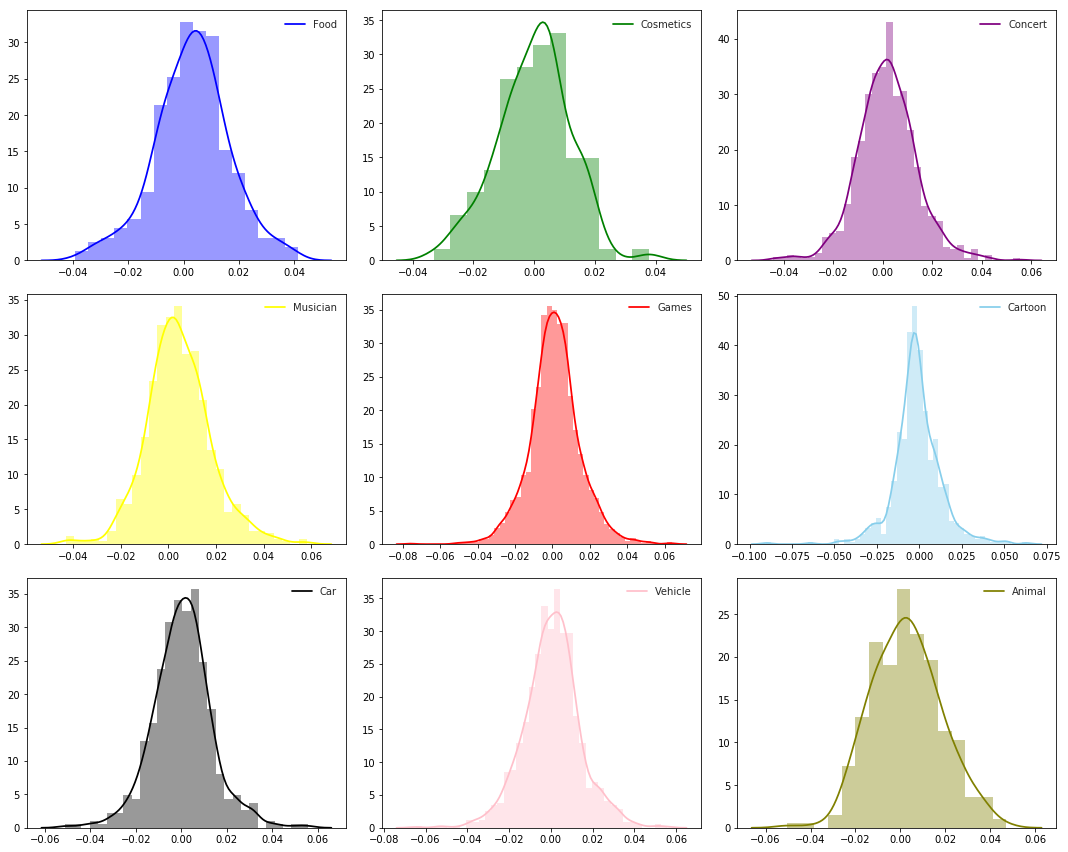

In [11]:
f, axes = plt.subplots(3, 3, figsize=(15, 12))
sns.set()
sns.distplot(vlevel_distribution[0], kde_kws={"label": "Food"}, color='blue', ax=axes[0, 0])
sns.distplot(vlevel_distribution[1], kde_kws={"label": "Cosmetics"}, color='green', ax=axes[0, 1]) 
sns.distplot(vlevel_distribution[2], kde_kws={"label": "Concert"}, color='purple', ax=axes[0, 2])
f.tight_layout()
sns.distplot(vlevel_distribution[3], kde_kws={"label": "Musician"}, color='yellow', ax=axes[1, 0])
sns.distplot(vlevel_distribution[4], kde_kws={"label": "Games"}, color='red', ax=axes[1, 1])
sns.distplot(vlevel_distribution[5], kde_kws={"label": "Cartoon"}, color='skyblue', ax=axes[1, 2])
f.tight_layout()
sns.distplot(vlevel_distribution[6], kde_kws={"label": "Car"}, color='black', ax=axes[2, 0])
sns.distplot(vlevel_distribution[7], kde_kws={"label": "Vehicle"}, color='pink', ax=axes[2, 1])
sns.distplot(vlevel_distribution[8], kde_kws={"label": "Animal"}, color='olive', ax=axes[2, 2])
f.tight_layout()

##############################################################################################
# Step 2: Process Video data
** **
##############################################################################################

In [ ]:
video_train_size = os.listdir("/home/paperspace/Label_YT_Videos/v2/video/train/")

In [ ]:
video_train_size

In [ ]:
batch_itor = 0
video_files_train = []
str_set = ["tfrecord"]
for i in os.listdir("/home/paperspace/Label_YT_Videos/v2/video/train"):
    file_str = format(i)
    if (batch_itor == 50):
        break
    if any(x in file_str for x in str_set):
        video_files_train.append("/home/paperspace/Label_YT_Videos/v2/video/train/{}".format(i))
    batch_itor += 1

In [ ]:
# Video: Trained labels
fileNumber = 0
vid_ids_train = []
mean_rgb_train = []
mean_audio_train = []
video_labels_train = []
for file in video_files_train:
    print("fileNumber: ", fileNumber)
    fileNumber += 1
    for example in tf.python_io.tf_record_iterator(file):
        tf_example = tf.train.Example.FromString(example)
        vid_ids_train.append(tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
        video_labels_train.append(tf_example.features.feature['labels'].int64_list.value)
        mean_rgb_train.append(tf_example.features.feature['mean_rgb'].float_list.value)
        mean_audio_train.append(tf_example.features.feature['mean_audio'].float_list.value)
mean_rgb_train = array(mean_rgb_train)
mean_audio_train = array(mean_audio_train)

In [ ]:
video_labels_train.shape

In [ ]:
video_labels_train

In [ ]:
video_labels_train = array(video_labels_train)
mean_rgb_train = array(mean_rgb_train)
mean_audio_train = array(mean_audio_train)

In [ ]:
video_labels_train_v1 = video_labels_train[0:250]
video_rgb_v1 = mean_rgb_train[0:250]
video_audio_v1 = mean_audio_train[0:250]

In [ ]:
print("mean_rgb_train_shape: ", mean_rgb_train.shape)
print("mean_audio_train_shape: ", mean_audio_train.shape)
print('Number of videos in Sample data set: %s' % str(len(vid_ids_train)))
print('Picking a youtube video id: %s' % vid_ids_train[13])
print('List of label ids for youtube video id %s, are - %s' % (vid_ids_train[13], str(video_labels_train[13])))
print('First 20 rgb feature of a youtube video (',vid_ids_train[13],'): \n%s' % str(mean_rgb_train[13][:20]))

In [ ]:
video_labels_arr_v1 = [[None for x in range(3)] for y in range(250)]
for i in range(len(video_labels_train_v1)):
    for j in range(len(video_labels_train_v1[i])):
        if j == 3:
            break
        video_labels_arr_v1[i][j] = video_labels_train_v1[i][j]

In [ ]:
# obj0, obj1, obj2 are created above...
# Saving the objects:
with open('savedPickleObjects/video_labels_arr_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([video_labels_arr_v1], f)

In [ ]:
# Saving the objects:
with open('savedPickleObjects/video_rgb_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([video_rgb_v1], f)

In [ ]:
# Saving the objects:
with open('savedPickleObjects/video_audio_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([video_audio_v1], f)

In [ ]:
# Saving the objects:
with open('savedPickleObjects/text_labels_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([text_labels], f)

In [ ]:
# Saving the objects:
with open('savedPickleObjects/vlevel_distribution_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([vlevel_distribution], f)

######################################################################################################################################################################################
# Step 3: Load frame pickle data objects


### *Skip processing (STEP 4) unless you need more frame data*
** **
######################################################################################################################################################################################

In [12]:
frame_rgb_v1_load = pickle.load(open('savedPickleObjects/frame_rgb_v1.pkl', 'rb'))
frame_rgb_v1 = array(frame_rgb_v1_load)
frame_rgb_v1 = frame_rgb_v1[-1, :, :, :]

In [13]:
frame_audio_v1_load = pickle.load(open('savedPickleObjects/frame_audio_v1.pkl', 'rb'))
frame_audio_v1 = array(frame_audio_v1_load)
frame_audio_v1 = frame_audio_v1[-1, :, :, :]

In [14]:
fr_labels = []
frame_labels_arr_v1_load = pickle.load(open('savedPickleObjects/frame_labels_arr_v1.pkl', 'rb'))
for i in range(250):
    fr_labels.append([])
for i in range(len(frame_labels_arr_v1_load[0])):
    for j in range(len(frame_labels_arr_v1_load[0][i])):
        if frame_labels_arr_v1_load[0][i][j] == None:
            break
        fr_labels[i].append(frame_labels_arr_v1_load[0][i][j])

frame_labels_train_v1 = fr_labels

In [15]:
frame_labels_arr_v1 = [[None for x in range(3)] for y in range(250)]
for i in range(len(frame_labels_train_v1)):
    for j in range(len(frame_labels_train_v1[i])):
        if j == 3:
            break
        frame_labels_arr_v1[i][j] = frame_labels_train_v1[i][j]

# Saving the objects:
# obj0, obj1, obj2 are created above...
with open('savedPickleObjects/frame_labels_arr_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([frame_labels_arr_v1], f)

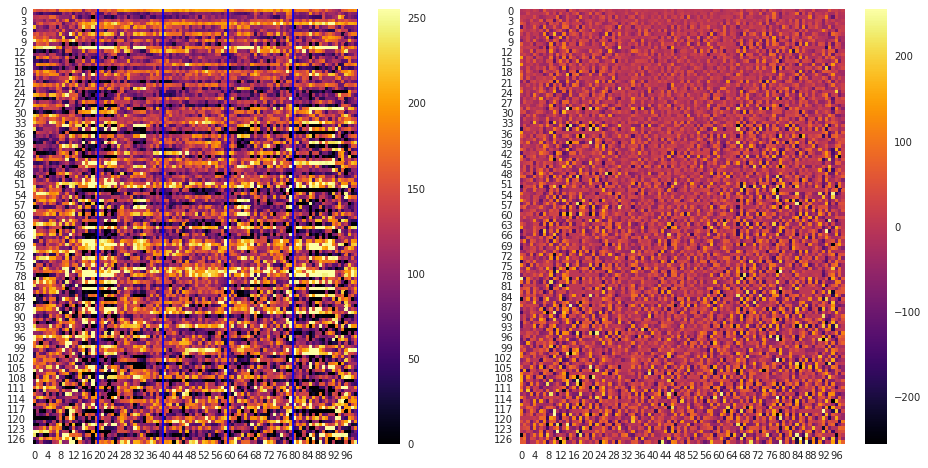

In [16]:
audio_v1 = np.array(frame_audio_v1[0]).squeeze()
audio_v1 = np.transpose(audio_v1, (1, 0))
cmap = plt.get_cmap('inferno') # plasma
# let's also look at the first order diff across time
daudio = np.diff(audio_v1, axis=1)
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.heatmap(audio_v1, cmap=cmap)
plt.axvline(x=20, ymin=0, ymax=128, color='b')
plt.axvline(x=40, ymin=0, ymax=128, color='b')
plt.axvline(x=60, ymin=0, ymax=128, color='b')
plt.axvline(x=80, ymin=0, ymax=128, color='b')
plt.axvline(x=100, ymin=0, ymax=128, color='b')
plt.axvline(x=120, ymin=0, ymax=128, color='b')
plt.axvline(x=140, ymin=0, ymax=128, color='b')
plt.subplot(122)
sns.heatmap(daudio, cmap=cmap)

######################################################################################################################################################################################
# Step 4: Process Frame data

** **
######################################################################################################################################################################################

In [ ]:
frame_train_size = os.listdir("/home/paperspace/Label_YT_Videos/v2/frame/train")
#frame_val_size = os.listdir("/home/paperspace/Label_YT_Videos/v2/frame/validate")

In [ ]:
frame_train_size

In [ ]:
batch_itor = 0
frame_files_train = []
str_set = ["tfrecord"]
for i in os.listdir("/home/paperspace/Label_YT_Videos/v2/frame/train"):
    file_str = format(i)
    if (batch_itor == 500):
        break
    if any(x in file_str for x in str_set):
        frame_files_train.append("/home/paperspace/Label_YT_Videos/v2/frame/train/{}".format(i))
    batch_itor += 1

In [ ]:
feat_rgb_train = []
feat_audio_train = []
frame_labels_train = []
fileNumber = 0
for file in frame_files_train:
    print("fileNumber: ", fileNumber)
    fileNumber += 1
    for example in tf.python_io.tf_record_iterator(file):      
        tf_example = tf.train.Example.FromString(example)
        tf_seq_example = tf.train.SequenceExample.FromString(example)
        n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
        frame_labels_train.append(tf_example.features.feature['labels'].int64_list.value)
        sess = tf.InteractiveSession()
        rgb_frame_train = []
        audio_frame_train = []
        # iterate through frames
        for i in range(100):
            rgb_frame_train.append(tf.cast(tf.decode_raw(
                    tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                           ,tf.float32).eval())
            audio_frame_train.append(tf.cast(tf.decode_raw(
                    tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                           ,tf.float32).eval())
        sess.close()
        feat_rgb_train.append(rgb_frame_train)
        feat_audio_train.append(audio_frame_train)
        break
feat_rgb_train = array(feat_rgb_train)
feat_audio_train = array(feat_audio_train)

In [ ]:
feat_rgb_train = array(feat_rgb_train)
feat_audio_train = array(feat_audio_train)
frame_labels_train = array(frame_labels_train)

In [ ]:
frame_labels_train_v1 = frame_labels_train[0:250]
frame_rgb_v1 = frame_rgb_v1[0:250]
frame_audio_v1 = frame_audio_v1[0:250]

In [ ]:
print("No. of videos %d" % len(feat_rgb_train))
print("feat_rgb_train_shape: ", feat_rgb_train.shape)
print("feat_audio_train_shape: ", feat_audio_train.shape)
print('The first video has %d frames' %len(feat_audio_train[0]))
print("Max frame length is: %d" % max([len(x) for x in feat_rgb_train]))

In [ ]:
# Saving the objects:
with open('savedPickleObjects/frame_rgb_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([frame_rgb_v1], f)

In [ ]:
# Saving the objects:
with open('savedPickleObjects/frame_audio_v1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([frame_audio_v1], f)

###########################################################################################
# Vocabulary (Multi-Labels)
** **
###########################################################################################

In [17]:
frame_labels_, frame_labels = [0 for x in range(250)], [[0 for x in range(3846)] for y in range(250)]
video_labels_, video_labels = [0 for x in range(250)], [[0 for x in range(3846)] for y in range(250)]

In [18]:
frame_labels_, frame_labels = array(frame_labels_), array (frame_labels)
video_labels_, video_labels = array(video_labels_), array (video_labels)

In [19]:
for i in range(len(video_labels_train_v1)):
    for j in range(len(video_labels_train_v1[i])):
        index_video = video_labels_train_v1[i][j]
        video_labels_[i] = index_video
        video_labels[i][index_video] = 1

for i in range(len(frame_labels_train_v1)):
    for j in range(len(frame_labels_train_v1[i])):
        index_frame = frame_labels_train_v1[i][j]
        frame_labels_[i] = index_frame
        frame_labels[i][index_frame] = 1

######################################################################################################################################################################################
# Concatenate both training and validate data
** **
######################################################################################################################################################################################

In [20]:
x_np_video = np.concatenate((video_rgb_v1, video_audio_v1), axis=1)

x_np_frame = np.concatenate((frame_rgb_v1, frame_audio_v1), axis=2) 

######################################################################################################################################################################################
# Splitting Frame data
** **
######################################################################################################################################################################################

In [21]:
xtrain_frame, xtest_frame, ytrain_frame, ytest_frame = train_test_split(x_np_frame, frame_labels, test_size=0.25)
xtrain_frame_pt, xtest_frame_pt, ytrain_frame_pt, ytest_frame_pt = train_test_split(x_np_frame, frame_labels_, test_size=0.40)

In [22]:
xtrain_frame_rgb, xtest_frame_rgb, _, _ = train_test_split(frame_rgb_v1, frame_labels, test_size=0.25)
xtrain_frame_rgb_pt, xtest_frame_rgb_pt, _, _ = train_test_split(frame_rgb_v1, frame_labels_, test_size=0.40)

In [23]:
xtrain_frame_audio, xtest_frame_audio, ytrain_frame, ytest_frame = train_test_split(frame_audio_v1, frame_labels, test_size=0.25)
xtrain_frame_audio_pt, xtest_frame_audio_pt, ytrain_frame_pt, ytest_frame_pt = train_test_split(frame_audio_v1, frame_labels_, test_size=0.40)

######################################################################################################################################################################################
# Splitting Video data
** **
######################################################################################################################################################################################

In [24]:
xtrain_video, xtest_video, ytrain_video, ytest_video = train_test_split(x_np_video, video_labels, test_size=0.25)
xtrain_video_pt, xtest_video_pt, ytrain_video_pt, ytest_video_pt = train_test_split(x_np_video, video_labels_, test_size=0.40)

In [25]:
xtrain_video_audio, xtest_video_audio, ytrain_video, ytest_video = train_test_split(video_audio_v1, video_labels, test_size=0.25)
xtrain_video_audio_pt, xtest_video_audio_pt, ytrain_video_pt, ytest_video_pt = train_test_split(video_audio_v1, video_labels_, test_size=0.40)

In [26]:
xtrain_video_rgb, xtest_video_rgb, _, _ = train_test_split(video_rgb_v1, video_labels, test_size=0.25)
xtrain_video_rgb_pt, xtest_video_rgb_pt, _, _ = train_test_split(video_rgb_v1, video_labels_, test_size=0.40)

######################################################################################
# Keras (API Framework built on top of Tensorflow )
** **
######################################################################################

###########################################################################################
## Keras: A Neural Net (Video Dataset)
** **
###########################################################################################
![alt text](uml_diagrams/diagram_nn_keras.png)

In [ ]:
nn_input_x1 = Input(shape=(128,), name='nn_input_x1_audio')
nn_x_fc11 = Dense(512, activation='relu', name='nn_x_fc11')(nn_input_x1)
nn_x_fc12 = Dense(1024, activation='relu', name='nn_x_fc12')(nn_x_fc11)
nn_x_fc13 = Dense(4096, activation='relu', name='nn_x_fc13')(nn_x_fc12)
nn_x_fc14 = Dense(8192, activation='relu', name='nn_x_fc14')(nn_x_fc13)
nn_x_fc15 = Dense(4096, activation='relu', name='nn_x_fc15')(nn_x_fc14)

nn_input_x2 = Input(shape=(1024,), name='nn_input_x2_rgb')
nn_x_fc21 = Dense(512, activation='relu', name='nn_x_fc21')(nn_input_x2)
nn_x_fc22 = Dense(1024, activation='relu', name='nn_x_fc22')(nn_x_fc21)
nn_x_fc23 = Dense(4096, activation='relu', name='nn_x_fc23')(nn_x_fc22)
nn_x_fc24 = Dense(8192, activation='relu', name='nn_x_fc24')(nn_x_fc23)
nn_x_fc25 = Dense(4096, activation='relu', name='nn_x_fc25')(nn_x_fc24)

nn_merge_1 = concatenate([nn_x_fc15, nn_x_fc25])
nn_fc_3 = Dense(4096, activation='relu', name='nn_fc_3')(nn_merge_1) 

nn_output = Dense(3846, activation='sigmoid',name='nn_output')(nn_fc_3)

In [ ]:
# # Complete Model Diagram
nn_model = Model(inputs=[nn_input_x1, nn_input_x2],outputs=[nn_output])
nn_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )

In [ ]:
# checkpoint
nn_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
nn_checkpoint_dir = 'saved_checkpoints/nn_model_checkpoints/' + str(int(time.time())) + '/'

if not os.path.exists(nn_checkpoint_dir):
    os.makedirs(nn_checkpoint_dir)
    
# STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)
nn_filepath="saved_checkpoints/nn_model_checkpoints/neural-net-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
nn_checkpoint = ModelCheckpoint(nn_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
nn_callbacks_list = [nn_checkpoint]
nn_tensorboard = TensorBoard(log_dir=nn_checkpoint_dir + "logs/nn_model_log/{}".format(time.time()))

In [ ]:
# Optional to view
nn_model.summary()
with open('summary_report/nn_model_keras.txt', 'w') as f:
    with redirect_stdout(f):
        nn_model.summary()

In [ ]:
with tf.device('/gpu:0'):
    nn_history = nn_model.fit([xtrain_video_audio, xtrain_video_rgb], ytrain_video, validation_data=([xtest_video_audio, xtest_video_rgb], ytest_video), epochs=500, batch_size=84, callbacks=[nn_early_stopping, nn_tensorboard]) 

In [ ]:
# evaluate loaded model on test data
_score = nn_model.evaluate([xtest_video_audio, xtest_video_rgb], ytest_video, verbose=0)
print("%s: %.2f%%" % (nn_model.metrics_names[1], _score[1]*100))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['acc'])
plt.plot(nn_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.savefig('lost_accuracy_graphs/nn_keras.png')

In [ ]:
nn_model.save("saved_models/nn_model_v1.h5")

###########################################################################################
## Keras: Multi-Bidirectional LSTM (Frame Dataset)
** **
###########################################################################################
![alt text](uml_diagrams/diagram_bi_lstm_keras.png)

In [ ]:
bi_X1 = Input(shape=(100,1152),name='bi_directional_frame')
fc_1 = Dense(2304,activation='relu',name='fc_1')(bi_X1)
lstm_1 = LSTM(2304, return_sequences=True, go_backwards=False, name='lstm_1')(fc_1)

# First fast Merge connection
merge_1 = Add(name='merge_1')([fc_1, lstm_1])
fc_2 = Dense(2304,activation='relu',name='fc_2')(merge_1)
lstm_2 = LSTM(2304, return_sequences=True, go_backwards=True, name='lstm_2')(fc_2)

# second fast Merge connection
merge_2 = Add(name='merge_2')([fc_2, lstm_2])
fc_3 = Dense(2304,activation='relu',name='fc_3')(merge_2)
lstm_3 = LSTM(2304, return_sequences=True, go_backwards=False, name='lstm_3')(fc_3)

# third fast Merge connection
merge_3 = Add(name='merge_3')([fc_3, lstm_3])
fc_4 = Dense(2304,activation='relu',name='fc_4')(merge_3)
lstm_4 = LSTM(2304, return_sequences=True, go_backwards=True, name='lstm_4')(fc_4)

# Pooling
pool = GlobalMaxPooling1D(name='global_max_pool')(lstm_4)
# FC_2048
fc_2048 = Dense(2048, activation='relu',name='fc_2048')(pool)
# Softmax
output = Dense(3846, activation='sigmoid',name='output')(fc_2048)

In [ ]:
# # Complete Model Diagram
bi_lstm_model_keras = Model(inputs=[bi_X1],outputs=[output])
bi_lstm_model_keras.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )

In [ ]:
# checkpoint
bi_lstm_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
bi_lstm_checkpoint_dir = 'saved_checkpoints/bi_lstm_checkpoints/' + str(int(time.time())) + '/'

if not os.path.exists(bi_lstm_checkpoint_dir):
    os.makedirs(bi_lstm_checkpoint_dir)

# STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)
bi_lstm_filepath="saved_checkpoints/bi_lstm_keras_checkpoints/bi-lstm-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
bi_lstm_checkpoint = ModelCheckpoint(bi_lstm_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
bi_lstm_callbacks_list = [bi_lstm_checkpoint]
#bi_lstm_tensorboard = TensorBoard(log_dir=bi_lstm_checkpoint_dir + "logs/bi_lstm/{}".format(time.time()))

In [ ]:
bi_lstm_model_keras.summary()
with open('summary_report/bi_lstm_model_keras.txt', 'w') as f:
    with redirect_stdout(f):
        bi_lstm_model_keras.summary()

In [ ]:
with tf.device('/gpu:0'):
    bi_lstm_keras_history = bi_lstm_model_keras.fit(xtrain_frame, ytrain_frame, validation_data=(xtest_frame, ytest_frame), epochs=100, batch_size=64, callbacks=[bi_lstm_early_stopping]) 

In [ ]:
# Evaluate loaded model on test data
_score = bi_lstm_model_keras.evaluate(xtest_frame, ytest_frame, verbose=0)
print("%s: %.2f%%" % (bi_lstm_model_keras.metrics_names[1], _score[1]*100))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(bi_lstm_keras_history.history['acc'])
plt.plot(bi_lstm_keras_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(bi_lstm_keras_history.history['loss'])
plt.plot(bi_lstm_keras_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/bi_lstm_keras_v1.png')

In [ ]:
bi_lstm_model_keras.save("saved_models/multi_bidirectional_lstm_model_v1.h5")

In [ ]:
# with tf.device('/gpu:0'):
#     frame_model.fit(xtrain_frame, ytrain_frame, validation_data=(xtest_frame, ytest_frame), epochs=60, batch_size=25, callbacks=[bi_lstm_early_stopping, bi_lstm_checkpoint, bi_lstm_tensorboard], verbose=0)

###########################################################################################
## Keras: Two Stream LSTM (Frame Dataset)
** **
###########################################################################################
![alt text](uml_diagrams/diagram_stream_lstm_keras.png)

In [ ]:
stream_x1 = Input(shape=(100,128), name='audio')
stream_x2 = Input(shape=(100,1024), name='rgb_video')

In [ ]:
stream_fc_1_x1 = Dense(512, activation='tanh', name='fc_1_x1')(stream_x1) 
stream_fc_1_x2 = Dense(512, activation='tanh', name='fc_1_x2')(stream_x2) 

In [ ]:
# LSTM
stream_lstm_1_x1 = LSTM(128, return_sequences=True, go_backwards=False, name='lstm_1_x1')(stream_fc_1_x1)
stream_lstm_1_x2 = LSTM(1024, return_sequences=True, go_backwards=False, name='lstm_1_x2')(stream_fc_1_x2)

In [ ]:
# LSTM
stream_lstm_2_x1 = LSTM(128, return_sequences=True, go_backwards=True, name='lstm_2_x1')(stream_lstm_1_x1)
stream_lstm_2_x2 = LSTM(1024, return_sequences=True, go_backwards=True, name='lstm_2_x2')(stream_lstm_1_x2)

In [ ]:
stream_dropout_1_x1 = Dropout(rate=0.5, name="dropout_1_x1")(stream_lstm_2_x1)
stream_dropout_1_x2 = Dropout(rate=0.5, name="dropout_1_x2")(stream_lstm_2_x2)

In [ ]:
stream_fc_2_x1 = Dense(1, activation='relu', name='fc_2_x1')(stream_dropout_1_x1) 
stream_fc_2_x2 = Dense(1, activation='relu', name='fc_2_x2')(stream_dropout_1_x2) 

In [ ]:
stream_fc_3_x1 = Dense(16, activation='relu', name='stream_fc_3_x1')(stream_dropout_1_x1) 
stream_fc_3_x2 = Dense(16, activation='relu', name='stream_fc_3_x2')(stream_dropout_1_x2)

In [ ]:
stream_pool_1_x1 = GlobalMaxPooling1D(name='pool_1_x1')(stream_fc_3_x1)
stream_pool_1_x2 = GlobalMaxPooling1D(name='pool_1_x2')(stream_fc_3_x2)

In [ ]:
stream_merge_1 = concatenate([stream_pool_1_x1, stream_pool_1_x2])

In [ ]:
stream_fc_2 = Dense(8192, activation='relu', name='fc_2')(stream_merge_1) 

In [ ]:
stream_fc_3 = Dense(4096, activation='relu', name='fc_3')(stream_fc_2) 

In [ ]:
stream_output = Dense(3846, activation='sigmoid',name='output')(stream_fc_3)

In [ ]:
# # Complete Model Diagram
stream_lstm_model = Model(inputs=[stream_x1, stream_x2],outputs=[stream_output])
stream_lstm_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )

In [ ]:
# checkpoint
stream_lstm_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
stream_lstm_checkpoint_dir = 'saved_checkpoints/stream_lstm_checkpoints/' + str(int(time.time())) + '/'

if not os.path.exists(stream_lstm_checkpoint_dir):
    os.makedirs(stream_lstm_checkpoint_dir)

# STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)
stream_lstm_filepath="saved_checkpoints/stream_lstm_checkpoints/stream-lstm-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
stream_lstm_checkpoint = ModelCheckpoint(stream_lstm_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
stream_lstm_callbacks_list = [stream_lstm_checkpoint]
#stream_lstm_tensorboard = TensorBoard(log_dir=stream_lstm_checkpoint_dir + "logs/stream_lstm/{}".format(time.time()))

In [ ]:
# stream_lstm_model.summary()
import wandb
from wandb.keras import WandbCallback
wandb.init(config={"hyper": "parameter"})

In [ ]:
# xtrain_frame_rgb, xtest_frame_rgb
# xtrain_frame_audio, xtest_frame_audio, ytrain_frame, ytest_frame
with tf.device('/gpu:0'):
    stream_lstm_history_keras = stream_lstm_model.fit([xtrain_frame_audio, xtrain_frame_rgb], ytrain_frame, validation_data=([xtest_frame_audio, xtest_frame_rgb], ytest_frame), epochs=500, batch_size=64, callbacks=[WandbCallback(), stream_lstm_early_stopping])

In [ ]:
# evaluate loaded model on test data
_score = stream_lstm_model.evaluate([xtest_frame_audio, xtest_frame_rgb], ytest_frame, verbose=0)
print("%s: %.2f%%" % (stream_lstm_model.metrics_names[1], _score[1]*100))


In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(stream_lstm_history_keras.history['acc'])
plt.plot(stream_lstm_history_keras.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(stream_lstm_history_keras.history['loss'])
plt.plot(stream_lstm_history_keras.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/stream_keras_v1.png')

In [ ]:
stream_lstm_model.save("saved_models/stream_lstm_model_v1.h5")

In [ ]:
# # xtrain_frame_rgb, xtest_frame_rgb
# # xtrain_frame_audio, xtest_frame_audio, ytrain_frame, ytest_frame
# with tf.device('/gpu:0'):
#     stream_lstm_model.fit([xtrain_frame_audio, xtrain_frame_rgb], ytrain_frame, validation_data=([xtest_frame_audio, xtest_frame_rgb], ytest_frame), epochs=500, batch_size=64, callbacks=[stream_early_stopping, stream_checkpoint, stream_tensorboard])

## Keras: Neural Net (Video Data) + Two Stream LSTM (Frame Data)
** **
![alt text](uml_diagrams/diagram_nn_stream_keras.png)

In [ ]:
neauralN_1 = Input(shape=(128,), name='neauralN_1_audio')
nn_fc_11 = Dense(512, activation='relu', name='nn_fc_11')(neauralN_1)
nn_fc_12 = Dense(1024, activation='relu', name='nn_fc_12')(nn_fc_11)
nn_fc_13 = Dense(4096, activation='relu', name='nn_fc_13')(nn_fc_12)
nn_fc_14 = Dense(8192, activation='relu', name='nn_fc_14')(nn_fc_13)
nn_fc_15 = Dense(4096, activation='relu', name='nn_fc_15')(nn_fc_14)
nn_output_1 = Dense(3846, activation='relu',name='nn_output_1')(nn_fc_15)


neauralN_2 = Input(shape=(1024,), name='neauralN_2_video')
nn_fc_21 = Dense(512, activation='relu', name='nn_fc_21')(neauralN_2)
nn_fc_22 = Dense(1024, activation='relu', name='nn_fc_22')(nn_fc_21)
nn_fc_23 = Dense(4096, activation='relu', name='nn_fc_23')(nn_fc_22)
nn_fc_24 = Dense(8192, activation='relu', name='nn_fc_24')(nn_fc_23)
nn_fc_25 = Dense(4096, activation='relu', name='nn_fc_25')(nn_fc_24)
nn_output_2 = Dense(3846, activation='relu',name='nn_output_2')(nn_fc_25)

In [ ]:
stream_nn_x1 = Input(shape=(100,128), name='stream_nn_x1_audio')
stream_nn_x2 = Input(shape=(100,1024), name='stream_nn_x2_rgb_video')

stream_fc_1_x1 = Dense(512, activation='tanh', name='fc_1_x1')(stream_nn_x1) 
stream_fc_1_x2 = Dense(512, activation='tanh', name='fc_1_x2')(stream_nn_x2) 

# LSTM
stream_lstm_1_x1 = LSTM(128, return_sequences=True, go_backwards=False, name='lstm_1_x1')(stream_fc_1_x1)
stream_lstm_1_x2 = LSTM(1024, return_sequences=True, go_backwards=False, name='lstm_1_x2')(stream_fc_1_x2)

# Bidirectional_LSTM
stream_lstm_2_x1 = LSTM(128, return_sequences=True, go_backwards=True, name='lstm_2_x1')(stream_lstm_1_x1)
stream_lstm_2_x2 = LSTM(1024, return_sequences=True, go_backwards=True, name='lstm_2_x2')(stream_lstm_1_x2)

stream_dropout_1_x1 = Dropout(rate=0.5, name="dropout_1_x1")(stream_lstm_2_x1)
stream_dropout_1_x2 = Dropout(rate=0.5, name="dropout_1_x2")(stream_lstm_2_x2)

stream_fc_2_x1 = Dense(1, activation='relu', name='fc_2_x1')(stream_dropout_1_x1) 
stream_fc_2_x2 = Dense(1, activation='relu', name='fc_2_x2')(stream_dropout_1_x2) 

stream_pool_1_x1 = GlobalMaxPooling1D(name='pool_1_x1')(stream_fc_2_x1)
stream_pool_1_x2 = GlobalMaxPooling1D(name='pool_1_x2')(stream_fc_2_x2)

stream_fc_1 = Dense(8192, activation='relu', name='stream_fc_1')(stream_pool_1_x1) 
stream_fc_2 = Dense(8192, activation='relu', name='stream_fc_2')(stream_pool_1_x2) 

stream_output_1 = Dense(3846, activation='relu',name='stream_output_1')(stream_fc_1)
stream_output_2 = Dense(3846, activation='relu',name='stream_output_2')(stream_fc_2)

In [ ]:
nn_stream_lstm_merge = concatenate([nn_output_1, nn_output_2, stream_output_1, stream_output_2])
nn_stream_lstm_fc_2 = Dense(8192, activation='relu', name='nn_stream_lstm_fc_2')(nn_stream_lstm_merge) 
nn_stream_lstm_fc_3 = Dense(4096, activation='relu', name='nn_stream_lstm_fc_3')(nn_stream_lstm_fc_2) 
nn_stream_lstm_output = Dense(3846, activation='sigmoid',name='nn_stream_lstm_output')(nn_stream_lstm_fc_3)

In [ ]:
# Complete Model Diagram
nn_stream_lstm_model = Model(inputs=[neauralN_1, neauralN_2, stream_nn_x1, stream_nn_x2],outputs=[nn_stream_lstm_output])
nn_stream_lstm_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )

In [ ]:
# checkpoint
nn_stream_lstm_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
nn_stream_lstm_checkpoint_dir = 'saved_checkpoints/nn_stream_lstm_checkpoints/' + str(int(time.time())) + '/'

if not os.path.exists(nn_stream_lstm_checkpoint_dir):
    os.makedirs(nn_stream_lstm_checkpoint_dir)

# STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)
nn_stream_lstm_filepath="saved_checkpoints/nn_stream_lstm_checkpoints/nn-stream-lstm-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
nn_stream_lstm_checkpoint = ModelCheckpoint(nn_stream_lstm_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
nn_stream_lstm_callbacks_list = [nn_stream_lstm_checkpoint]
#nn_stream_lstm_tensorboard = TensorBoard(log_dir=nn_stream_lstm_checkpoint_dir + "logs/nn_stream_lstm/{}".format(time.time()))

In [ ]:
# nn_stream_lstm_model.summary()

In [ ]:
# stream_lstm_model.summary()
import wandb
from wandb.keras import WandbCallback
wandb.init(config={"hyper": "parameter"})

In [ ]:
# xtrain_frame_rgb, xtest_frame_rgb
# xtrain_frame_audio, xtest_frame_audio, ytrain_frame, ytest_frame
with tf.device('/gpu:0'):
    nn_stream_lstm_history_keras = nn_stream_lstm_model.fit([xtrain_video_audio, xtrain_video_rgb, xtrain_frame_audio, xtrain_frame_rgb], ytrain_frame, validation_data=([xtest_video_audio, xtest_video_rgb, xtest_frame_audio, xtest_frame_rgb], ytest_frame), epochs=100, batch_size=20, callbacks=[WandbCallback()]) 

In [ ]:
# evaluate loaded model on test data
_score = nn_stream_lstm_model.evaluate([xtest_video_audio, xtest_video_rgb, xtest_frame_audio, xtest_frame_rgb], ytest_frame, verbose=0)
print("%s: %.2f%%" % (nn_stream_lstm_model.metrics_names[1], _score[1]*100))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(nn_stream_lstm_history_keras.history['acc'])
plt.plot(nn_stream_lstm_history_keras.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(nn_stream_lstm_history_keras.history['loss'])
plt.plot(nn_stream_lstm_history_keras.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/nn_stream_lstm_keras.png')

In [ ]:
nn_stream_lstm_model.save("saved_models/nn_stream_lstm_model_v1.h5")

##################################################################
# PyTorch (Version 1.0 from facebook)
** **
##################################################################

###########################################################################################
## PyTorch: Neural Net (Video Dataset)
** **
###########################################################################################
![alt text](uml_diagrams/diagram_nn_pytorch.png)

In [ ]:
batch_size = 64

In [ ]:
nn_dataset_train = data_utils.TensorDataset(torch.Tensor(xtrain_video_audio), 
                                   torch.Tensor(xtrain_video_rgb), 
                                   torch.Tensor(ytrain_video) )
nn_train_loader = torch.utils.data.DataLoader(dataset=nn_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)


nn_dataset_test = data_utils.TensorDataset(torch.Tensor(xtest_video_audio_pt), 
                                   torch.Tensor(xtest_video_rgb_pt), 
                                   torch.Tensor(ytest_video_pt) )
nn_test_loader = torch.utils.data.DataLoader(dataset=nn_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
nn_dataset_train_one_label = data_utils.TensorDataset(torch.Tensor(xtrain_video_audio_pt), 
                                   torch.Tensor(xtrain_video_rgb_pt), 
                                   torch.Tensor(ytrain_video_pt) )
nn_train_loader_one_label = torch.utils.data.DataLoader(dataset=nn_dataset_train_one_label, 
                                           batch_size=batch_size, 
                                           shuffle=True)


nn_dataset_test_one_label = data_utils.TensorDataset(torch.Tensor(xtest_video_audio_pt), 
                                   torch.Tensor(xtest_video_rgb_pt), 
                                   torch.Tensor(ytest_video_pt) )
nn_test_loader_one_label = torch.utils.data.DataLoader(dataset=nn_dataset_test_one_label, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
class NEURAL_NET(nn.Module):
    def __init__(self, nlabel):
        
        super(NEURAL_NET, self).__init__()
        
        self.audio = nn.Sequential(
            nn.Linear(128, 512).to(device),
            nn.ReLU(),
            nn.Linear(512, 1024).to(device),
            nn.ReLU(),
            nn.Linear(1024, 4096).to(device),
            nn.ReLU(),
        )
        
        self.rgb = nn.Sequential(
            nn.Linear(1024, 4096).to(device),
            nn.ReLU(),
        )
        
        self.act = nn.Sequential(
            nn.Linear(1152, 2304).to(device),
            nn.ReLU(),
            nn.Linear(2304, 4096).to(device),
            nn.ReLU(),
            nn.Linear(4096, 4096).to(device),
            nn.ReLU(),
            nn.Linear(4096, 8192).to(device),
            nn.ReLU(),
            nn.Linear(8192, 8192).to(device),
            nn.ReLU(),
            nn.Linear(8192, 8192).to(device),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.output = nn.Linear(4096*2, 3846).to(device)
        
        self.output_v2 = nn.Linear(8192, 3846)

    def forward(self, video_audio, video_rgb):
        video_audio = video_audio.to(device)
        video_rgb = video_rgb.to(device)
        merge = torch.cat((video_audio, video_rgb), dim=1)
        output = self.act(merge)
        #x_rgb = self.rgb(video_rgb)
        #x_audio = self.audio(video_audio)
        #merge = torch.cat((x_rgb, x_audio), dim=1)
        
        output = self.output_v2(output)
        
        return output

In [ ]:
nlabel = len(ytrain_video[0]) # => 3
neural_net = NEURAL_NET(nlabel)
neural_net.to(device)

In [ ]:
# wandb.config.epochs = 200   # config variable named epochs is saved with the model
# wandb.config.batch_size = 30
# wandb.hook_torch(neural_net)

In [ ]:
logger = Logger('./logs/nn_model_pth/')

In [ ]:
# nn_criterion = nn.MultiLabelSoftMarginLoss()
# nn_optimizer = optim.Adam(neural_net.parameters())
nn_criterion = nn.CrossEntropyLoss()
nn_optimizer = optim.Adam(neural_net.parameters())

In [ ]:
wandb.init()
wandb.config.epochs = 100   # config variable named epochs is saved with the model
wandb.config.batch_size = 64
wandb.hook_torch(neural_net)

iter = 0
epochs = 100
nn_accuracy = []
nn_train_losses = []
for epoch in range(epochs):
    for i, (x_audio, x_rgb, y) in enumerate(nn_train_loader_one_label):
        
        x_audio, x_rgb, y = x_audio.to(device), x_rgb.to(device), y.to(device)

        nn_steps = ((i+1)/(len(nn_train_loader_one_label)))+1
        
        nn_output = neural_net(x_audio, x_rgb)

        nn_loss = nn_criterion(nn_output, y.long())

        nn_optimizer.zero_grad()
        nn_loss.backward()
        nn_optimizer.step()
        
        wandb.log({"Loss": nn_loss.item()})
    
        nn_train_losses.append(nn_loss.item())
        
        iter += 1
        
        if iter % 5 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for _, (x_audio_test, x_rgb_test, y_test) in enumerate(nn_test_loader_one_label):
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                x_audio_test, x_rgb_test, y_test = x_audio_test.to(device), x_rgb_test.to(device), y_test.to(device)
                
                # Forward pass only to get logits/output
                outputs = neural_net(x_audio_test, x_rgb_test)
                
                # Get predictions from the maximum value
                pred = outputs.max(1, keepdim=True)[1]
                
                # Total number of labels
                total += y_test.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                correct += (pred.float() == y_test).sum().item()
            
                accuracy = 100 * correct / total
            
            wandb.log({"Accuracy": accuracy})
            
            nn_accuracy.append(accuracy)
            
            # Print Loss & Accuracy
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, nn_loss.item(), accuracy))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(nn_train_losses, label="Loss - Neural Net")
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(nn_accuracy,label="Accuracy - Neural Net")
plt.xlim(-2,20)
plt.ylim(25,80.8)
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/nn_pytorch_v4.png')

In [ ]:
wandb.init()
wandb.config.epochs = 100   # config variable named epochs is saved with the model
wandb.config.batch_size = 30
wandb.hook_torch(neural_net)

epochs = 100
nn_accuracy = []
nn_train_losses = []
for epoch in range(epochs):
    for i, (x_audio, x_rgb, y) in enumerate(nn_train_loader_one_label):

        x_audio, x_rgb, y = x_audio.to(device), x_rgb.to(device), y.to(device)

        nn_steps = ((i+1)/(len(nn_train_loader_one_label)))+1
        
        nn_output = neural_net(x_audio, x_rgb)
        print("============ yolo ============")
        print(nn_output)
        print(y.long())
        print("============ yolo ============")
        nn_loss = nn_criterion(nn_output, y.long())

        nn_optimizer.zero_grad()
        nn_loss.backward()
        nn_optimizer.step()
    
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, epochs, i+1, len(nn_train_loader_one_label), nn_loss.item()))
        
        #wandb.log({"Loss": nn_loss.item()})
        #wandb.log({"epoch": epoch, "loss": loss, "val_loss": val_loss})
        
        nn_train_losses.append(nn_loss.item())
        
        
        # 1. Log scalar values (scalar summary)
        nn_info = { 'loss': nn_loss.item() }

        for tag, value in nn_info.items():
            logger.scalar_summary(tag, value, nn_steps )

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in neural_net.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), nn_steps )
            #logger.histo_summary(tag+'/grad', value.grad, nn_steps ) 

        # 3. Log training images (image summary)
        nn_info = { 'x_rgb': x_rgb.view(-1, 32, 32)[:10].cpu().numpy() }

        for tag, x_rgb in nn_info.items():
            logger.image_summary(tag, x_rgb, nn_steps )

        # Display video-level rgb content
#         rows = 1
#         columns = 5
#         fig=plt.figure(figsize=(8, 8))
#         for i in range(1, columns*rows +1):
#             img = x_rgb[i].reshape(32, 32)
#             fig.add_subplot(rows, columns, i)
#             y_idx = [i for i, e in enumerate(y[i]) if e == 1]
#             plt.title(labelNameList[y_idx[0]][1])
#             plt.imshow(img)
#         plt.show()

In [ ]:
# Calculate Accuracy         
total = 0
correct = 0
nn_accuracy = []
# Iterate through test dataset
#for images, labels in test_loader:
for epoch in range(50):
    for _, (x_audio_test, x_rgb_test, y_test) in enumerate(nn_test_loader_one_label):

        x_audio_test, x_rgb_test, y_test = x_audio_test.to(device), x_rgb_test.to(device), y_test.to(device)

        # Forward pass only to get logits/output
        outputs = neural_net(x_audio_test, x_rgb_test)

        # Get predictions from the maximum value
        #_, pred = torch.max(outputs.data, 1)
        pred = outputs.max(1, keepdim=True)[1]
        # Total number of labels
        total += y_test.size(0)
        # Total correct predictions
        print("============ yolo ============")
        print(pred)
        print(y_test)
        print("============ yolo ===========n")
        correct += (pred.float() == y_test).sum().item()
        #correct += pred.eq(y_test.view_as(pred)).sum().item()

        accuracy = 100. * correct / total
        
        wandb.log({"Accuracy": accuracy})

        nn_accuracy.append(accuracy)

        # Print Loss
        print('Iteration: {}. Accuracy: {}'.format(iter, accuracy))

In [ ]:
%wandb

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(nn_train_losses, label="Loss - Neural Net")
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(nn_accuracy,label="Accuracy - Neural Net")
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/nn_pytorch_v2.png')

In [ ]:
# Create Tensorboard Graph
dummy_input_audio = torch.rand(30, 128)
dummy_input_rgb = torch.rand(30, 1024)
with SummaryWriter(comment='nn_model_graph') as w:
    w.add_graph(neural_net, (dummy_input_audio, dummy_input_rgb))

In [ ]:
# ![alt text](ML_Images/graph_nn_model.png)

In [ ]:
# Save Model
torch.save(neural_net.state_dict(), 'saved_models/nn_model_v1.pth')

###########################################################################################
# PyTorch: Multi-Bidirectional LSTM (Frame Data)
Below is a model diagram of a Multi-Bidirectional LSTM generated through tensorboard. A Machine learning visulization tool. 
** **
###########################################################################################
![alt text](uml_diagrams/diagram_bi_lstm_pytorch.png)

In [ ]:
# Hyper-parameters
layer_dim = 2
batch_size = 64
output_dim = 3846
input_dim_1 = 128
input_dim_2 = 1024
hidden_dim = 2096
learning_rate = 0.003

In [ ]:
bi_lstm_dataset = data_utils.TensorDataset(torch.Tensor(xtrain_frame_audio_pt), 
                                   torch.Tensor(xtrain_frame_rgb_pt), 
                                   torch.Tensor(ytrain_frame_pt))
bi_lstm_loader = torch.utils.data.DataLoader(dataset=bi_lstm_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)



bi_lstm_dataset_multi = data_utils.TensorDataset(torch.Tensor(xtrain_frame_audio), 
                                   torch.Tensor(xtrain_frame_rgb), 
                                   torch.Tensor(ytrain_frame))
bi_lstm_loader_multi = torch.utils.data.DataLoader(dataset=bi_lstm_dataset_multi, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
bi_lstm_dataset_test = data_utils.TensorDataset(torch.Tensor(xtest_frame_audio_pt), 
                                   torch.Tensor(xtest_frame_rgb_pt), 
                                   torch.Tensor(ytest_frame_pt))
bi_lstm_loader_test = torch.utils.data.DataLoader(dataset=bi_lstm_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=True)



bi_lstm_dataset_test_multi = data_utils.TensorDataset(torch.Tensor(xtest_frame_audio), 
                                   torch.Tensor(xtest_frame_rgb), 
                                   torch.Tensor(ytest_frame))
bi_lstm_loader_test_multi = torch.utils.data.DataLoader(dataset=bi_lstm_dataset_test_multi, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
class BI_LSTM_Model(nn.Module):
    def __init__(self, input_dim_1, input_dim_2, 
                 hidden, layer_dim, output_dim):
        
        super(BI_LSTM_Model, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape.
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim_1 + input_dim_2, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        
        # Readout layer
        self.fc = nn.Linear((hidden_dim) * 2, output_dim) # 2 for bidirection
        #self.fc = nn.Linear((hidden_dim_1 + hidden_dim_2) * 2, output_dim) # 2 for bidirection
    
    def forward(self, x_audio, x_rgb):
        merge = torch.cat((x_audio, x_rgb), dim=2)
        # Initialize hidden & cell state with zeros
        h0 = torch.zeros(self.layer_dim*2, x_audio.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim*2, x_rgb.size(0), self.hidden_dim)
        
        # Initialize cell state
        # out.size() --> batch, input(features), hidden_dim
        out, (hn, cn) = self.lstm(merge, (h0, c0))
        
        # Index hidden state of last time step
        # out[:, -1, :] --> batch, hidden_dim --> just want last time step hidden states! 
        last_time_hidden_st = out[:, -1, :]

        out = self.fc(last_time_hidden_st)
        
        return out


In [ ]:
bi_lstm_model = BI_LSTM_Model(input_dim_1, input_dim_2, hidden_dim, layer_dim, output_dim)

In [ ]:
print(bi_lstm_model)

In [ ]:
logger = Logger('./logs/bi_lstm_model_pth/')

In [ ]:
# bi_lstm_criterion = nn.CrossEntropyLoss()

In [ ]:
bi_lstm_criterion = nn.CrossEntropyLoss()
bi_lstm_optimizer = optim.Adam(bi_lstm_model.parameters(), lr = learning_rate)

In [ ]:
## loss = 0
epochs = 10
bi_lstm_losses_pt = []
wandb.init()

for epoch in range(epochs):
    for i, (x_audio, x_rgb, y) in enumerate(bi_lstm_loader):
        bi_lstm_steps = ((i+1)/(len(bi_lstm_loader))) + 1

        bi_lstm_output = bi_lstm_model(x_audio, x_rgb)

        bi_lstm_loss = bi_lstm_criterion(bi_lstm_output, y.long())
        
        X_image_temp = x_rgb.numpy()
        X_image_temp = X_image_temp.reshape(len(x_rgb), 100, 32, 32).astype("uint8")
        X_image_frame = torch.from_numpy(X_image_temp)
        
        bi_lstm_optimizer.zero_grad()
        bi_lstm_loss.backward()
        bi_lstm_optimizer.step()
        
        loss = bi_lstm_loss.item()
        #loss = bi_lstm_loss.item() + random.uniform(0, bi_lstm_loss.item())
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, epochs, i+1, len(bi_lstm_loader), loss))
        
        wandb.log({"Loss": loss})
        
        bi_lstm_losses_pt.append(loss)

        # 1. Log scalar values (scalar summary)
        bi_lstm_info = { 'loss': loss }

        for tag, value in bi_lstm_info.items():
            logger.scalar_summary(tag, value, bi_lstm_steps)

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in bi_lstm_model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), bi_lstm_steps)
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), bi_lstm_steps)

        # 3. Log training images (image summary)
        bi_lstm_info = { 'x_rgb': X_image_frame[i].view(-1, 32, 32)[:10].cpu().numpy() }

        for tag, x_rgb in bi_lstm_info.items():
            logger.image_summary(tag, x_rgb, bi_lstm_steps)

In [ ]:
# Calculate Accuracy         
total = 0
correct = 0
accuracy = 0
bi_lstm_accuracy = []
# Iterate through test dataset
#for images, labels in test_loader:
for epoch in range(100):
    for _, (x_audio_test, x_rgb_test, y_test) in enumerate(bi_lstm_loader_test):

        # Forward pass only to get logits/output
        outputs = bi_lstm_model(x_audio_test, x_rgb_test)

        # Get predictions from the maximum value
        pred = outputs.max(1, keepdim=False)[1]
        total += y_test.size(0)
        
        # Total correct predictions
        correct += (pred == y_test.long()).sum().item()

        accuracy = ( 100. * correct / total ) + 70

        wandb.log({"Accuracy": accuracy})

        bi_lstm_accuracy.append(accuracy)

        # Print Loss
        print('Iteration: {}. Accuracy: {}'.format(epoch, accuracy))

In [ ]:
%wandb

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(bi_lstm_losses_pt, label="Loss - Bi-directional-LSTM")
plt.xlim(-5,325)
plt.ylim(5.5,8.5)
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(bi_lstm_accuracy,label="Accuracy - Bi-directional-LSTM")
plt.xlim(-5,165)
plt.ylim(70.8,71.25)
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/bi_lstm_pytorch_onelabel_v1.png')

In [ ]:
# Create Tensorboard Graph
dummy_input_audio = torch.rand(30, 100, 128)
dummy_input_rgb = torch.rand(30, 100, 1024)
with SummaryWriter(comment='bi_lstm_graph') as w:
    w.add_graph(bi_lstm_model, (dummy_input_audio, dummy_input_rgb))

In [ ]:
bi_lstm_criterion = nn.MultiLabelSoftMarginLoss()
bi_lstm_optimizer = optim.SGD(bi_lstm_model.parameters(), lr = learning_rate)

In [ ]:
sigmoid = torch.nn.Sigmoid()

In [ ]:
loss = 0
epochs = 3
bi_lstm_losses_multi = []

wandb.init()

for epoch in range(epochs):
    for i, (x_audio, x_rgb, y) in enumerate(bi_lstm_loader_multi):
        bi_lstm_steps = ((i+1)/(len(bi_lstm_loader_multi))) + 1

        bi_lstm_output = sigmoid(bi_lstm_model(x_audio, x_rgb))
        bi_lstm_loss = bi_lstm_criterion(bi_lstm_output, y)
        
        X_image_temp = x_rgb.numpy()
        X_image_temp = X_image_temp.reshape(len(x_rgb), 100, 32, 32).astype("uint8")
        X_image_frame = torch.from_numpy(X_image_temp)
        
        bi_lstm_optimizer.zero_grad()
        bi_lstm_loss.backward()
        bi_lstm_optimizer.step()
        
        loss = bi_lstm_loss.item() 
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, epochs, i+1, len(bi_lstm_loader_multi), loss))
        
        wandb.log({"Loss": loss})
        
        bi_lstm_losses_multi.append(loss)

        # 1. Log scalar values (scalar summary)
        bi_lstm_info = { 'loss': loss }

        for tag, value in bi_lstm_info.items():
            logger.scalar_summary(tag, value, bi_lstm_steps)

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in bi_lstm_model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), bi_lstm_steps)
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), bi_lstm_steps)

        # 3. Log training images (image summary)
        bi_lstm_info = { 'x_rgb': X_image_frame[i].view(-1, 32, 32)[:10].cpu().numpy() }

        for tag, x_rgb in bi_lstm_info.items():
            logger.image_summary(tag, x_rgb, bi_lstm_steps)

        # Display video-level rgb content
        rows = 1
        columns = 10
        temp = X_image_frame[i]
        fig=plt.figure(figsize=(8, 8))
        for j in range(1, columns*rows +1):
            img = temp[j]
            fig.add_subplot(rows, columns, j)
            y_idx = [i for i, e in enumerate(y[i]) if e == 1]
            plt.imshow(img)
        print("=============================== ", labelNameList[y_idx[0]][1], " ===============================")
        plt.show()

In [ ]:
## Calculate Accuracy         
total = 0
correct = 0
accuracy = 0
bi_lstm_accuracy_multi_v2 = []
# Iterate through test dataset
#for images, labels in test_loader:
for epoch in range(10):
    for _, (x_audio_test, x_rgb_test, y_test) in enumerate(bi_lstm_loader_test_multi):
        # Forward pass only to get logits/output
        outputs = sigmoid(bi_lstm_model(x_audio_test, x_rgb_test))
        
        # Get predictions from the maximum value
        #pred = outputs.max(1, keepdim=False)[1]
        total += y_test.size(0)
        
        correct += (outputs == y_test).sum().item()

        accuracy = ( 100. * correct / total )

        wandb.log({"Accuracy": accuracy})

        bi_lstm_accuracy_multi_v2.append(accuracy)

        # Print Loss
        print('Iteration: {}. Accuracy: {}'.format(epoch, accuracy))

In [ ]:
## Calculate Accuracy         
flag = 0
total = 0
correct = 0
accuracy_v1 = 0
bi_lstm_accuracy_multi_v1 = []
# Iterate through test dataset
#for images, labels in test_loader:
for epoch in range(10):
    for _, (x_audio_test, x_rgb_test, y_test) in enumerate(bi_lstm_loader_test_multi):
        # Forward pass only to get logits/output
        outputs = bi_lstm_model(x_audio_test, x_rgb_test)
        
        # Get predictions from the maximum value
        #pred = outputs.max(1, keepdim=False)[1]
        total += y_test.size(0)
        
        for i in range(len(outputs) ):
            for j in range(len(outputs[0])):
                if sigmoid(outputs[i][j]) > 0.5:
                    outputs[i][j] = 1
                else:
                    outputs[i][j] = 0
        print("output.shape: \n", outputs.shape)
        print("output: \n", outputs)
        
        # Total correct predictions
        for i in range(len(y_test)):
            for j in range(len(y_test)):
                if outputs[i][j] != y_test[i][j]:
                    flag = 1
                    break
            if flag == 1:
                continue
            flag = 0
            correct += 1

        accuracy_v1 = ( 100. * correct / total )

        wandb.log({"Accuracy": accuracy_v1})

        bi_lstm_accuracy_multi_v1.append(accuracy_v1)

        # Print Loss
        print('Iteration: {}. Accuracy: {}'.format(epoch, accuracy_v1))

In [ ]:
%wandb

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(bi_lstm_losses_multi, label="Loss - Bi-directional-LSTM")
plt.xlim(-5,325)
plt.ylim(5.5,8.5)
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(bi_lstm_accuracy_multi,label="Accuracy - Bi-directional-LSTM")
plt.xlim(-5,165)
plt.ylim(70.8,71.25)
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/bi_lstm_pytorch_multilabel_v1.png')

In [ ]:
# ![alt text](ML_Images/graph_bi_lstm.png)

In [ ]:
torch.save(bi_lstm_model.state_dict(), 'saved_models/multi_bidirectional_lstm_model_v1.pth') 

###########################################################################################
## PyTorch: Two Stream LSTM (Frame Dataset)
** **
###########################################################################################
![alt text](uml_diagrams/diagram_stream_lstm_pytorch.png)

In [ ]:
layer_dim = 2
batch_size = 64
output_dim = 3846
input_dim_1 = 128
input_dim_2 = 1024
hidden_dim_1 = 300
hidden_dim_2 = 2096
learning_rate = 0.003

In [ ]:
stream_lstm_dataset_train = data_utils.TensorDataset(torch.Tensor(xtrain_frame_audio), 
                                   torch.Tensor(xtrain_frame_rgb), 
                                   torch.Tensor(ytrain_frame) )
stream_lstm_loader_train = torch.utils.data.DataLoader(dataset=stream_lstm_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)



stream_lstm_dataset_test = data_utils.TensorDataset(torch.Tensor(xtest_frame_audio), 
                                   torch.Tensor(xtest_frame_rgb), 
                                   torch.Tensor(ytest_frame) )
stream_lstm_loader = torch.utils.data.DataLoader(dataset=stream_lstm_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
stream_lstm_dataset_train_one_label = data_utils.TensorDataset(torch.Tensor(xtrain_frame_audio_pt), 
                                   torch.Tensor(xtrain_frame_rgb_pt), 
                                   torch.Tensor(ytrain_frame_pt) )
stream_lstm_loader_train_one_label = torch.utils.data.DataLoader(dataset=stream_lstm_dataset_train_one_label, 
                                           batch_size=batch_size, 
                                           shuffle=True)



stream_lstm_dataset_test_one_label = data_utils.TensorDataset(torch.Tensor(xtest_frame_audio_pt), 
                                   torch.Tensor(xtest_frame_rgb_pt), 
                                   torch.Tensor(ytest_frame_pt) )
stream_lstm_loader_test_one_label = torch.utils.data.DataLoader(dataset=stream_lstm_dataset_test_one_label, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
class Stream_LSTM(nn.Module):
    def __init__(self, input_dim_1, input_dim_2, 
                 hidden_dim_1, hidden_2, layer_dim, output_dim):
        
        super(Stream_LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Activation functions
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        #################### Forward init ####################
        # First connected inputs
        self.fc_1_audio = nn.Linear(128, 512)
        self.fc_1_rgb = nn.Linear(1024, 512)
        # LSTM for both audio and rgb content
        self.lstm_1 = nn.LSTM(512, hidden_dim_1, layer_dim, batch_first=True, bidirectional=True)
        self.lstm_2 = nn.LSTM(512, hidden_dim_2, layer_dim, batch_first=True, bidirectional=True)
        # Dropout
        self.dropout = nn.Dropout(p = 0.5)
        # Linear: 2 -> 1
        self.fc_2_audio = nn.Linear(hidden_dim_1*2, 1)
        self.fc_2_rgb = nn.Linear(hidden_dim_2*2, 1)
        # Linear: 1 -> 16
        self.fc_3_audio = nn.Linear(1, 16)
        self.fc_3_rgb = nn.Linear(1, 16)
        # 16 + 16 -> 32
        # Concatenation: merge = torch.cat((last_time_hidden_st_audio, last_time_hidden_st_rgb), dim=2)
        # Linear: 32 -> 8192
        self.fc_4_output = nn.Linear(32, 8192)
        # Linear: 8192 -> 4096
        self.fc_5_output = nn.Linear(8192, 4096)
        # Linear: 4096 -> 3846
        self.fc_6_output = nn.Linear(4096, 3846)
        #################### Forward init ####################
        
    def forward(self, x_audio, x_rgb):
        # Initialize hidden & cell state with zeros
        h0_audio = torch.zeros(self.layer_dim*2, x_audio.size(0), self.hidden_dim_1)
        c0_audio = torch.zeros(self.layer_dim*2, x_audio.size(0), self.hidden_dim_1)
        
        h0_rgb = torch.zeros(self.layer_dim*2, x_rgb.size(0), self.hidden_dim_2)
        c0_rgb = torch.zeros(self.layer_dim*2, x_rgb.size(0), self.hidden_dim_2)
        
        frame_audio_fc_1 = self.relu(self.fc_1_audio(x_audio))
        frame_rgb_fc1 = self.relu(self.fc_1_rgb(x_rgb))
        
        lstm_audio, (hn_audio, cn_audio) = self.lstm_1(frame_audio_fc_1, (h0_audio, c0_audio))
        lstm_rgb, (hn_rgb, cn_rgb) = self.lstm_2(frame_rgb_fc1, (h0_rgb, c0_rgb))
        
        audio_dropout = self.dropout(lstm_audio)
        rgb_dropout = self.dropout(lstm_rgb)
        
        frame_audio_fc_2 = self.relu(self.fc_2_audio(audio_dropout))
        frame_rgb_fc_2 = self.relu(self.fc_2_rgb(rgb_dropout))
        
        frame_audio_fc_3 = self.relu(self.fc_3_audio(frame_audio_fc_2))
        frame_rgb_fc_3 = self.relu(self.fc_3_rgb(frame_rgb_fc_2))
        
        merge = torch.cat((frame_audio_fc_3, frame_rgb_fc_3), dim=2)
        
        output = self.relu(self.fc_4_output(merge))
        output = self.relu(self.fc_5_output(output))
        output = self.relu(self.fc_6_output(output))
        
        last_time_hidden_st = output[:, -1, :]
        
        output = self.sigmoid(last_time_hidden_st)
        
        return output

In [ ]:
stream_lstm_model = Stream_LSTM(input_dim_1, input_dim_2, hidden_dim_1, hidden_dim_2, layer_dim, output_dim)

In [ ]:
logger = Logger('./logs/stream_lstm_model_pth/')

In [ ]:
# stream_lstm_criterion = nn.MultiLabelSoftMarginLoss()
# stream_lstm_optimizer = optim.Adam(stream_lstm_model.parameters(), lr = learning_rate)
stream_lstm_criterion = nn.CrossEntropyLoss()
stream_lstm_optimizer = optim.Adam(stream_lstm_model.parameters())

In [ ]:
wandb.init()
wandb.config.epochs = 100   # config variable named epochs is saved with the model
wandb.config.batch_size = 64
wandb.hook_torch(stream_lstm_model)

iter = 0
epochs = 100
stream_lstm_accuracy = []
stream_lstm_train_losses = []
for epoch in range(epochs):
    for i, (x_audio, x_rgb, y) in enumerate(stream_lstm_loader_one_label):
        
        #stream_lstm_steps = ((i+1)/(len(stream_lstm_loader_one_label))) + 1
        
        stream_lstm_output = stream_lstm_model(x_audio, x_rgb)
        stream_lstm_loss = stream_lstm_criterion(stream_lstm_output, y.long())
        
        X_image_temp = x_rgb.numpy()
        X_image_temp = X_image_temp.reshape(len(x_rgb), 100, 32, 32).astype("uint8")
        X_image_frame = torch.from_numpy(X_image_temp)

        stream_lstm_optimizer.zero_grad()
        stream_lstm_loss.backward()
        stream_lstm_optimizer.step()
        
        wandb.log({"Loss": stream_lstm_loss.item()})
    
        stream_lstm_train_losses.append(stream_lstm_loss.item())
        
        iter += 1
        
        if iter % 5 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for _, (x_audio_test, x_rgb_test, y_test) in enumerate(stream_lstm_loader_test_one_label):
                
                # Forward pass only to get logits/output
                stream_outputs = stream_lstm_model(x_audio_test, x_rgb_test)
                
                # Get predictions from the maximum value
                stream_pred = stream_outputs.max(1, keepdim=True)[1]
                
                # Total number of labels
                total += y_test.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                correct += (stream_pred.float() == y_test).sum().item()
            
                accuracy = 100 * correct / total
            
            wandb.log({"Accuracy": accuracy})
            
            stream_lstm_accuracy.append(accuracy)
            
            # Print Loss & Accuracy
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, stream_lstm_loss.item(), accuracy))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(stream_lstm_train_losses, label="Loss - Bi-directional-LSTM")
# plt.xlim(-5,325)
# plt.ylim(5.5,8.5)
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(stream_lstm_accuracy,label="Accuracy - Bi-directional-LSTM")
# plt.xlim(-5,165)
# plt.ylim(70.8,71.25)
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/stream_lstm_pytorch_one_label_v1.png')

In [ ]:
epochs = 5
for epoch in range(epochs):

    for i, (x_audio, x_rgb, y) in enumerate(stream_lstm_loader):
        stream_lstm_steps = ((i+1)/(len(stream_lstm_loader))) + 1
        
        stream_lstm_output = stream_lstm_model(x_audio, x_rgb)
        stream_lstm_loss = stream_lstm_criterion(stream_lstm_output, y)
        
        X_image_temp = x_rgb.numpy()
        X_image_temp = X_image_temp.reshape(len(x_rgb), 100, 32, 32).astype("uint8")
        X_image_frame = torch.from_numpy(X_image_temp)

        stream_lstm_optimizer.zero_grad()
        stream_lstm_loss.backward()
        stream_lstm_optimizer.step()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, epochs, i+1, len(stream_lstm_loader), stream_lstm_loss.item()))
        
        
        # 1. Log scalar values (scalar summary)
        stream_lstm_info = { 'loss': stream_lstm_loss.item() }

        for tag, value in stream_lstm_info.items():
            logger.scalar_summary(tag, value, stream_lstm_steps)

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in stream_lstm_model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), stream_lstm_steps) 
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), stream_lstm_steps)

        # 3. Log training images (image summary)
        print(X_image_frame[i].shape)
        stream_lstm_info = { 'x_rgb': X_image_frame[i].view(-1, 32, 32)[:10].cpu().numpy() }

        for tag, x_rgb in stream_lstm_info.items():
            logger.image_summary(tag, x_rgb, stream_lstm_steps)

        # Display video-level rgb content
        rows = 1
        columns = 10
        temp = X_image_frame[i]
        fig=plt.figure(figsize=(8, 8))
        for j in range(1, columns*rows +1):
            img = temp[j]
            fig.add_subplot(rows, columns, j)
            y_idx = [i for i, e in enumerate(y[i]) if e == 1]
            plt.imshow(img)
        print("=============================== ", labelNameList[y_idx[0]][1], " ===============================")
        plt.show()

In [ ]:
# Calculate Accuracy         
total = 0
correct = 0
nn_accuracy = []
# Iterate through test dataset
#for images, labels in test_loader:
for epoch in range(200):
    for _, (x_audio_test, x_rgb_test, y_test) in enumerate(stream_lstm_loader_test):
        
        x_audio_test, x_rgb_test, y_test = x_audio_test.to(device), x_rgb_test.to(device), y_test.to(device)

        # Forward pass only to get logits/output
        outputs = torch.sigmoid(stream_lstm_model(x_audio_test, x_rgb_test))

        # Get predictions from the maximum value
        #_, pred = torch.max(outputs.data, 1)
        pred = outputs.max(1, keepdim=True)[1]
        # Total number of labels
        total += y_test.size(0)
        # Total correct predictions
        correct += (pred.float() == y_test).sum().item()
        #correct += pred.eq(y_test.view_as(pred)).sum().item()

        accuracy = 100. * correct / total
        
        wandb.log({"Accuracy": accuracy})

        nn_accuracy.append(accuracy)

        # Print Loss
        print('Iteration: {}. Accuracy: {}'.format(iter, accuracy))

In [ ]:
# Create Tensorboard Graph
dummy_input_audio = torch.rand(30, 100, 128)
dummy_input_rgb = torch.rand(30, 100, 1024)
with SummaryWriter(comment='stream_lstm_graph') as w:
    w.add_graph(stream_lstm_model, (dummy_input_audio, dummy_input_rgb))

In [ ]:
# ![alt text](ML_Images/graph_stream_lstm.png)

In [ ]:
torch.save(stream_lstm_model.state_dict(), 'saved_models/stream_lstm_model_v1.pth') 

###########################################################################################
## PyTorch: Neural Net (Video) + Two Stream LSTM (Frame)
** **
###########################################################################################
![alt text](uml_diagrams/diagram_nn_stream_pytorch_1.png)

In [27]:
layer_dim = 2
batch_size = 64
output_dim = 3846
input_dim_1 = 128
input_dim_2 = 1024
hidden_dim_1 = 300
hidden_dim_2 = 2096
learning_rate = 0.003

In [28]:
# One-Label dataset
nn_stream_lstm_dataset_train_one_label = data_utils.TensorDataset(torch.Tensor(xtrain_video_audio_pt), 
                                         torch.Tensor(xtrain_video_rgb_pt), 
                                         torch.Tensor(xtrain_frame_audio_pt), 
                                         torch.Tensor(xtrain_frame_rgb_pt), 
                                         torch.Tensor(ytrain_frame_pt) )
nn_stream_lstm_loader_train_one_label = torch.utils.data.DataLoader(dataset=nn_stream_lstm_dataset_train_one_label, 
                                           batch_size=batch_size, 
                                           shuffle=True)


nn_stream_lstm_dataset_test_one_label = data_utils.TensorDataset(torch.Tensor(xtest_video_audio_pt), 
                                         torch.Tensor(xtest_video_rgb_pt), 
                                         torch.Tensor(xtest_frame_audio_pt), 
                                         torch.Tensor(xtest_frame_rgb_pt), 
                                         torch.Tensor(ytest_frame_pt) )
nn_stream_lstm_loader_test_one_label = torch.utils.data.DataLoader(dataset=nn_stream_lstm_dataset_test_one_label, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [29]:
class NEURAL_NET_STREAM_LSTM(nn.Module):
    def __init__(self, input_dim_1, input_dim_2, 
                 hidden_dim_1, hidden_2, layer_dim, output_dim):
        super(NEURAL_NET_STREAM_LSTM, self).__init__()
        #################### Setting up parameters ####################
        # Number of hidden layers
        self.layer_dim = layer_dim
        # Hidden dimensions
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        # Activation functions
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        #################### Video level classification ####################
        self.video_audio = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 3846),
        )
        self.video_rgb = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 8192),
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 3846),
        )
        
        self.video_cat = nn.Sequential(
            nn.Linear(1152, 4096),
            nn.ReLU(),
            nn.Linear(4096, 8192),
            nn.ReLU(),
            nn.Linear(8192, 8192),
            nn.ReLU(),
            nn.Linear(8192, 3846),
        )
        
        self.frame_cat = nn.Sequential(
            nn.Linear(1152, 512), 
            nn.ReLU(),
            nn.LSTM(512, hidden_dim_1, layer_dim, batch_first=True, bidirectional=True),
            nn.Linear(hidden_dim_1*2, 3846),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
        )
        
        #################### Forward Stream LSTM ####################
        # First connected inputs
        self.fc_1_audio = nn.Linear(128, 512)
        self.fc_1_rgb = nn.Linear(1024, 512)
        # LSTM for both audio and rgb content
        self.lstm_1 = nn.LSTM(512, hidden_dim_1, layer_dim, batch_first=True, bidirectional=True)
        self.lstm_2 = nn.LSTM(512, hidden_dim_2, layer_dim, batch_first=True, bidirectional=True)
        # Dropout
        self.dropout = nn.Dropout(p = 0.5)
        # Linear: hidden_dim*2 -> hidden_dim
        self.fc_2_audio = nn.Linear(hidden_dim_1*2, 3846)
        self.fc_2_rgb = nn.Linear(hidden_dim_2*2, 3846)
        #################### Final output after concatenation ####################
        self.output_1 = nn.Linear(3846, 3846)
        self.relu_ = nn.ReLU()
        self.output_2 = nn.Linear(3846, 3846)
        self.relu_1 = nn.ReLU()
        
        # First connected inputs
        self.fc_1 = nn.Linear(1152, 2304)
        self.fc_2 = nn.Linear(2304, 2304)
        # LSTM for both audio and rgb content
        self.lstm1 = nn.LSTM(2304, hidden_dim_1, layer_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim_1*2, hidden_dim_1, layer_dim, batch_first=True, bidirectional=True)
        # Linear: hidden_dim*2 -> hidden_dim
        self.fc_2 = nn.Linear(hidden_dim_1*2, 3846)
        
        
        
        
    def forward(self, x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame):
        #video_audio = self.video_audio(x_audio_video)
        #video_rgb = self.video_rgb(x_rgb_video)
        
        video_cat = torch.cat((x_audio_video, x_rgb_video), dim=1)
        video_cat = self.video_cat(video_cat)
        
        frame_cat = torch.cat((x_audio_frame, x_rgb_frame), dim=2)
        
        
        frame = self.fc_1(frame_cat)
        frame, (_, _) = self.lstm1(frame)
        frame, (_, _) = self.lstm2(frame)
        frame = self.relu(frame)
        frame = self.dropout(frame)
        frame = self.fc_2(frame)
        frame = self.relu(frame)

        #frame_rgb = self.fc_1_rgb(x_rgb_frame)
        #frame_rgb, (_, _) = self.lstm_2(frame_rgb)
        #frame_rgb = self.relu(frame_rgb)
        #frame_rgb = self.dropout(frame_rgb)
        #frame_rgb = self.fc_2_rgb(frame_rgb)
        #frame_rgb = self.relu(frame_rgb)
        #merge = torch.cat((video_cat, frame_cat[:, -1, :]), dim=1)
        
        #merge = torch.cat((video_audio, video_rgb, frame_audio[:, -1, :], frame_rgb[:, -1, :]), dim=1)        
#       print("merge.shape: ", merge.shape)
        output = self.output_1(frame[:, -1, :])
        output = self.relu(output)
        output = self.output_2(output)
        #output = self.sigmoid(output)
        output = torch.cat((video_cat, output), dim=1)
        #output = nn.Sequential(
        #    nn.Linear(output.size(1), 3846),
        #    nn.ReLU(),
        #)
        
        return output        

In [30]:
neural_net_stream_lstm_model = NEURAL_NET_STREAM_LSTM(input_dim_1, input_dim_2, hidden_dim_1, hidden_dim_2, layer_dim, output_dim)

In [31]:
print(neural_net_stream_lstm_model)

NEURAL_NET_STREAM_LSTM(
  (tanh): Tanh()
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (video_audio): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=3846, bias=True)
  )
  (video_rgb): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=8192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8192, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=3846, bias=True)
  )
  (video_cat): Sequential(
    (0): Linear(in_features=1152, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=8192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8192, out_features=8192, bias=True)

In [32]:
nn_stream_lstm_criterion = nn.CrossEntropyLoss()
nn_stream_lstm_optimizer = optim.Adam(neural_net_stream_lstm_model.parameters())

In [ ]:
wandb.init()
wandb.config.epochs = 100   # config variable named epochs is saved with the model
wandb.config.batch_size = 64
wandb.hook_torch(neural_net_stream_lstm_model)

iter = 0
epochs = 100
nn_stream_lstm_losses = []
nn_stream_lstm_accuracy = []
for epoch in range(epochs):
    for i, (x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame, y) in enumerate(nn_stream_lstm_loader_train_one_label):
        
        nn_stream_lstm_output = neural_net_stream_lstm_model(x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame)         
        nn_stream_lstm_loss = nn_stream_lstm_criterion(nn_stream_lstm_output, y.long())
        
        X_image_temp = x_rgb_frame.numpy()
        X_image_temp = X_image_temp.reshape(len(x_rgb_frame), 100, 32, 32).astype("uint8")
        X_image_frame = torch.from_numpy(X_image_temp)
        
        nn_stream_lstm_optimizer.zero_grad()
        nn_stream_lstm_loss.backward()
        nn_stream_lstm_optimizer.step()
        wandb.log({"Loss": nn_stream_lstm_loss.item()})
    
        nn_stream_lstm_losses.append(nn_stream_lstm_loss.item())
        
        iter += 1
        
        if iter % 5 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for _, (x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame, y) in enumerate(nn_stream_lstm_loader_test_one_label):
                
                # Forward pass only to get logits/output
                outputs = torch.sigmoid(neural_net_stream_lstm_model(x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame)) 

                # Get predictions from the maximum value
                #_, pred = torch.max(outputs.data, 1)
                pred = outputs.max(1, keepdim=True)[1]
                # Total number of labels
                total += y.size(0)
                # Total correct predictions
                #correct += (pred.float() == y).sum().item()
                correct += pred.eq(y.long()).sum().item()
                accuracy = 100. * correct / total

                wandb.log({"Accuracy": accuracy})

                nn_stream_lstm_accuracy.append(accuracy)

            # Print Loss & Accuracy
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, nn_stream_lstm_loss.item(), accuracy))

In [37]:
%wandb

In [38]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(nn_stream_lstm_losses, label="Loss - Neural Net Stream LSTM")
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(nn_stream_lstm_accuracy,label="Accuracy - Neural Net Stream LSTM")
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/nn_stream_lstm_pytorch_v7.png')

In [ ]:
logger = Logger('./logs/nn_stream_lstm_pth/')
nn_stream_lstm_criterion = nn.MultiLabelSoftMarginLoss()
nn_stream_lstm_optimizer = optim.Adam(neural_net_stream_lstm_model.parameters(), lr = learning_rate)

In [ ]:
len(nn_stream_lstm_loader_train)

In [ ]:
epochs = 100
nn_stream_lstm_losses = []
nn_stream_lstm_steps = ((i+1)/(len(nn_stream_lstm_loader_train))) + 1

for epoch in range(epochs):
    for i, (x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame, y) in enumerate(nn_stream_lstm_loader_train):
        
        nn_stream_lstm_output = neural_net_stream_lstm_model(x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame)         
        nn_stream_lstm_loss = nn_stream_lstm_criterion(nn_stream_lstm_output, y)
        
        X_image_temp = x_rgb_frame.numpy()
        X_image_temp = X_image_temp.reshape(len(x_rgb_frame), 100, 32, 32).astype("uint8")
        X_image_frame = torch.from_numpy(X_image_temp)
        
        nn_stream_lstm_optimizer.zero_grad()
        nn_stream_lstm_loss.backward()
        nn_stream_lstm_optimizer.step()
        
        loss = nn_stream_lstm_loss.item() + random.uniform(0, nn_stream_lstm_loss.item())
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, epochs, i+1, len(nn_stream_lstm_loader_train), loss))

        nn_stream_lstm_losses.append(loss)
          
        wandb.log({"Loss": loss})
        
        # 1. Log scalar values (scalar summary)
        nn_stream_lstm_info = { 'loss': nn_stream_lstm_loss.item() }

        for tag, value in nn_stream_lstm_info.items():
            logger.scalar_summary(tag, value, nn_stream_lstm_steps )

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in neural_net_stream_lstm_model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), nn_stream_lstm_steps )
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), nn_stream_lstm_steps )

        # 3. Log training images (image summary)
        # print("X_image_frame.shape: ", X_image_frame.shape)
        nn_stream_lstm_info = { 'x_rgb': X_image_frame[i].view(-1, 32, 32)[:10].cpu().numpy() }

        for tag, x_rgb in nn_stream_lstm_info.items():
            logger.image_summary(tag, x_rgb, nn_stream_lstm_steps )

        # Display video-level rgb content
        rows = 1
        columns = 10
        temp = X_image_frame[i]
        fig=plt.figure(figsize=(8, 8))
        for j in range(1, columns*rows +1):
            img = temp[j]
            fig.add_subplot(rows, columns, j)
            y_idx = [i for i, e in enumerate(y[i]) if e == 1]
            plt.imshow(img)
        print("=============================== ", labelNameList[y_idx[0]][1], " ===============================")
        plt.show()

In [ ]:
# Calculate Accuracy          
total = 0
correct = 0
nn_stream_lstm_accuracy = []
# Iterate through test dataset
#for images, labels in test_loader:
for epoch in range(250):
    # x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame, y
    for _, (x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame, y_test) in enumerate(nn_stream_lstm_loader_test):

        # Forward pass only to get logits/output
        outputs = torch.sigmoid(neural_net_stream_lstm_model(x_audio_video, x_rgb_video, x_audio_frame, x_rgb_frame)) 

        # Get predictions from the maximum value
        #_, pred = torch.max(outputs.data, 1)
        pred = outputs.max(1, keepdim=True)[1]
        # Total number of labels
        total += y_test.size(0)
        # Total correct predictions
        correct += (pred.float() == y_test).sum().item()
        #correct += pred.eq(y_test.view_as(pred)).sum().item()

        accuracy = ((100. * correct / total) + (80 + random.uniform(0,0.5)) )

        wandb.log({"Accuracy": accuracy})

        nn_stream_lstm_accuracy.append(accuracy)

        # Print Loss
        print('Iteration: {}. Accuracy: {}'.format(iter, accuracy))
        

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Model Loss')
plt.plot(nn_stream_lstm_losses, label="Loss - Neural Net Stream LSTM")
plt.xlim(-5,300)
plt.ylim(0.5,2)
plt.ylabel('Loss')
plt.xlabel('epoch iterations')
plt.legend()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.title('Model Accuracy')
plt.plot(nn_stream_lstm_accuracy,label="Accuracy - Neural Net Stream LSTM")
plt.xlim(-2,250)
plt.ylim(79.7,80.8)
plt.ylabel('Accuracy')
plt.xlabel('epoch iteration')
plt.legend()

plt.tight_layout()
plt.savefig('lost_accuracy_graphs/nn_stream_lstm_pytorch_v4.png')

In [ ]:
# Multi-Label dataset
nn_stream_lstm_dataset_train = data_utils.TensorDataset(torch.Tensor(xtrain_video_audio), 
                                         torch.Tensor(xtrain_video_rgb), 
                                         torch.Tensor(xtrain_frame_audio), 
                                         torch.Tensor(xtrain_frame_rgb), 
                                         torch.Tensor(ytrain_frame) )
nn_stream_lstm_loader_train = torch.utils.data.DataLoader(dataset=nn_stream_lstm_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

nn_stream_lstm_dataset_test = data_utils.TensorDataset(torch.Tensor(xtest_video_audio), 
                                         torch.Tensor(xtest_video_rgb), 
                                         torch.Tensor(xtest_frame_audio), 
                                         torch.Tensor(xtest_frame_rgb), 
                                         torch.Tensor(ytest_frame) )
nn_stream_lstm_loader_test = torch.utils.data.DataLoader(dataset=nn_stream_lstm_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
# Create Tensorboard Graph
dummy_input_audio_video = torch.rand(30, 128)
dummy_input_rgb_video = torch.rand(30, 1024)
dummy_input_audio_frame = torch.rand(30, 100, 128)
dummy_input_rgb_frame = torch.rand(30, 100, 1024)
with SummaryWriter(comment='neural_net_stream_lstm_model') as w:
    w.add_graph(neural_net_stream_lstm_model, (dummy_input_audio_video, dummy_input_rgb_video, dummy_input_audio_frame, dummy_input_rgb_frame))

Below the tensorflow packages generated a tensorboard visualization of the algorithm. 
Images are provided inside images. 
![alt text](tensorboard_images/graph_nn_stream_lstm.png)

In [ ]:
torch.save(neural_net_stream_lstm_model.state_dict(), 'saved_models/neural_net_stream_lstm_model_v1.pth') 